# IMPORTS

In [4]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       1.4.0
aiohttp                       3.9.0
aiosignal                     1.2.0
appdirs                       1.4.4
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.1
astunparse                    1.6.3
async-timeout                 4.0.3
attrs                         23.1.0
audioread                     3.0.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
beautifulsoup4                4.12.3
bleach                        4.1.0
blinker                       1.6.2
Bottleneck                    1.3.5
Brotli                        1.0.9
cachetools                    4.2.2
certifi                       2024.2.2
cffi                          1.16.0
charset-normalizer            2.0.4
chart-studio                  1.1.0
click                         8.1.7
colorama                      0.4.6
comm       

In [5]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [6]:
pip install tensorflow-gpu


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "c:\Users\pc\miniconda3\envs\hands-on-machine-learning\lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "c:\Users\pc\miniconda3\envs\hands-on-machine-learning\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "c:\Users\pc\miniconda3\envs\hands-on-machine-learning\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "c:\Users\pc\miniconda3\envs\hands-on-machine-learning\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 126, in 

In [7]:
import os 
import cv2 
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [8]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [9]:
tf.config.list_physical_devices('GPU')

[]

## For Better peroformance

In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    print('not found')

not found


# Build Data Loading functions


In [11]:
import gdown

In [12]:
url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

KeyboardInterrupt: 

In [13]:
from typing import List

def load_video(path:str)->List[float]:
    
    cap =cv2.VideoCapture(path)
    frames = []
    for _ in range (int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) # isolating the mouth part
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [14]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?123456789 "]

In [15]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [16]:

import tensorflow as tf
char_to_num =tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char =tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size=39)


In [17]:
def load_alignments(path:str)-> List[str]:
    with open(path,'r')as f:
        lines=f.readlines()
    tokens=[]
    for line in lines:
        line = line.split()
        if line[2]!='sil':
            tokens=[*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]


In [18]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    # file_anme =path.split('/')[-1].split('.')[0] # for linux
    #file name splitting for windows
    file_name =path.split('\\')[-1].split('.')[0]
    video_path =os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames =load_video(video_path)
    alignments=load_alignments(alignment_path)

    return frames,alignments

In [19]:
import numpy 

In [20]:
test_patth= '.\\data\\s1\\bbal6n.mpg'

In [21]:
tf.convert_to_tensor(test_patth).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [22]:
frames, alignments=load_data(tf.convert_to_tensor(test_patth))


In [23]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 38,  2, 12, 21,  5, 38,  1, 20, 38, 12, 38, 19,  9, 24,
       38, 14, 15, 23], dtype=int64)>

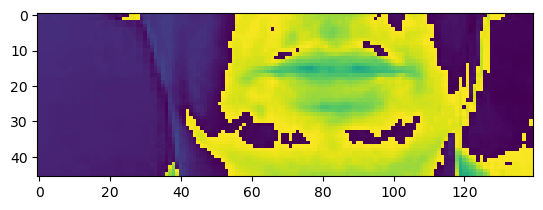

In [24]:
plt.imshow(frames[45])


In [25]:
def mappable_function(path:str)->List[str]:
    result = tf.py_function(load_data,[path], (tf.float32,tf.int64))
    return result

# Create Data Pipeline

In [71]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)


In [72]:
len(test)

50

In [73]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [74]:
frames,alignments= data.as_numpy_iterator().next()

In [75]:
test = data.as_numpy_iterator()

In [76]:
val=test.next(); val[0]

array([[[[[1.3491127 ],
          [1.3491127 ],
          [1.3491127 ],
          ...,
          [8.994085  ],
          [9.51874   ],
          [0.        ]],

         [[1.3491127 ],
          [1.3491127 ],
          [1.3491127 ],
          ...,
          [8.881659  ],
          [9.556215  ],
          [0.        ]],

         [[1.3491127 ],
          [1.3491127 ],
          [1.3491127 ],
          ...,
          [9.51874   ],
          [0.22485213],
          [0.22485213]],

         ...,

         [[0.9743592 ],
          [0.9743592 ],
          [0.9743592 ],
          ...,
          [0.07495071],
          [0.03747535],
          [0.03747535]],

         [[0.9743592 ],
          [0.9743592 ],
          [0.9743592 ],
          ...,
          [0.03747535],
          [0.03747535],
          [0.03747535]],

         [[0.9743592 ],
          [0.9743592 ],
          [0.9743592 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.3491

In [77]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)


TypeError: Cannot handle this data type: (1, 1, 1), <f4

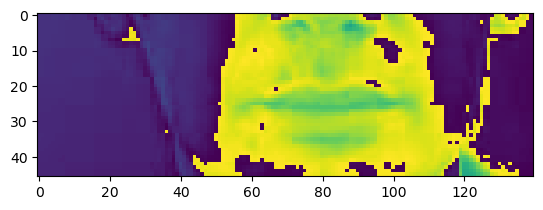

In [78]:
plt.imshow(val[0][0][0])

In [79]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d five soon'>

In [80]:
val

(array([[[[[1.3491127 ],
           [1.3491127 ],
           [1.3491127 ],
           ...,
           [8.994085  ],
           [9.51874   ],
           [0.        ]],
 
          [[1.3491127 ],
           [1.3491127 ],
           [1.3491127 ],
           ...,
           [8.881659  ],
           [9.556215  ],
           [0.        ]],
 
          [[1.3491127 ],
           [1.3491127 ],
           [1.3491127 ],
           ...,
           [9.51874   ],
           [0.22485213],
           [0.22485213]],
 
          ...,
 
          [[0.9743592 ],
           [0.9743592 ],
           [0.9743592 ],
           ...,
           [0.07495071],
           [0.03747535],
           [0.03747535]],
 
          [[0.9743592 ],
           [0.9743592 ],
           [0.9743592 ],
           ...,
           [0.03747535],
           [0.03747535],
           [0.03747535]],
 
          [[0.9743592 ],
           [0.9743592 ],
           [0.9743592 ],
           ...,
           [0.        ],
           [0.        

# Design The Neural Network

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Softmax,Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape,SpatialDropout3D, BatchNormalization, TimeDistributed,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [82]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [83]:
model = Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal", return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal", return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

# Setup Training Options and Train

In [85]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [86]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")

    input_length=input_length*tf.ones(shape=(batch_len, 1),dtype="int64")
    label_length=label_length*tf.ones(shape=(batch_len, 1),dtype="int64")

    loss=tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    return loss


In [92]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [93]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [94]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [95]:
schedule_callback = LearningRateScheduler(scheduler)


In [96]:
example_callback = ProduceExample(test)


In [97]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100


122/450 [=======>......................] - ETA: 50:41 - loss: 103.1475

# Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')


In [ ]:
test_data = test.as_numpy_iterator()


In [ ]:
sample = test_data.next()


In [ ]:
yhat = model.predict(sample[0])


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video


In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
